In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils
from load_dataset import load_dataset, feature_extraction

pd.set_eng_float_format(accuracy=2, use_eng_prefix=True)

data_directory = "/Users/nepal/Documents/synapthesis/synData6July"
lotti_fn = "export_lotti_veneto_2016_2018_giulio_v2.csv"
vincitori_fn = "export_vincitori_veneto_2016_2018_giulio_v2.csv"
procedura_fn = "tipi_procedure.csv"

df = load_dataset(data_directory, lotti_fn, vincitori_fn, procedura_fn)
df = feature_extraction(df)
df.dtypes

importo values to substitute with importo_base_asta values           percentage: 0.0012%
data_inizio values to substitute with data_inferita values           percentage: 0.3145%
columns dropped with mostly missing values:
['oggetto', 'importo_liquidato', 'importo_base_asta', 'data_inferita', 'id_mod_realizz', 'cpv_vero']
dropped all the rows with at least one missing value


id_pa                                int64
id_scelta_contraente                 int64
importo                            float64
data_inizio                 datetime64[ns]
data_fine                   datetime64[ns]
id_lsf                               int64
id_forma_giuridica_pa                int64
uber_forma_giuridica_pa             object
cpv                                  int64
id_be                                int64
id_forma_giuridica_be                int64
uber_forma_giuridica_be             object
procedura                           object
tipo_procedura                      object
median_expenditure_pa              float64
median_revenue_be                  float64
contr_med_pa                       float64
contr_med_be                       float64
durata                     timedelta64[ns]
durata_month                       float64
durata_year                        float64
day_of_year_sin                    float64
day_of_year_cos                    float64
med_yearly_

# anni e luogo dei contratti
2016, 2017, 2018 - regione Veneto

# abc analysis for award procedures and cpv codes

In [ ]:
fig, ax = plt.subplots()
abc_scelta_contraente = utils.plot_abc_items(df, "id_scelta_contraente", ax, .9)

In [ ]:
fig, ax = plt.subplots(figsize=(6*2, 4))
abc_cpv = utils.plot_abc_items(df, "cpv", ax, .64)

In [124]:
abc_procedures = [1, 26, 4, 23]
abc_cpv = [33, 45, 85, 79]

procedure_mask = df.id_scelta_contraente == abc_procedures[0]
for item in abc_procedures:
    procedure_mask += df.id_scelta_contraente == item
df = df[procedure_mask]

cpv_mask = df.cpv == abc_cpv[0]
for item in abc_cpv:
    cpv_mask += df.cpv == item
df = df[cpv_mask]

# Scaling

In [156]:
for i in range(1, 4):
    table = df[df.id_lsf == i]
    p = sum(table.durata.dt.days == 0) / len(table)
    print(i, p)

1 0.04571217916225059
2 0.13801483219508107
3 0.3936232647830305


[]

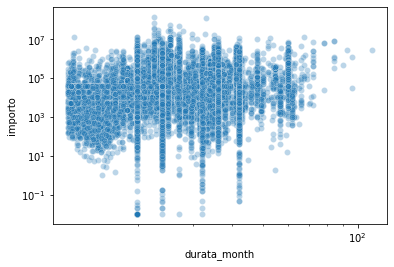

In [46]:
_, ax = plt.subplots()
sns.scatterplot(x="durata_month", y="importo", 
                data=df[(df.id_lsf==3) & (df.durata_month > 12)], ax=ax,
                alpha=.3)
ax.loglog()

In [158]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
table = df[df.id_lsf == 3][["durata_month", "median_revenue_be"]]
table["durata_month"].replace(0, table.durata_month.median())
X = table.values
y = df[df.id_lsf == 3].importo.values 
model.fit(X, y)
print(model.coef_)
model.score(X, y)

[5.04398932e+03 1.17917058e-02]


0.008962116341873827

71.21471575016078
60.0 200.0 399.0


<AxesSubplot:ylabel='Count'>

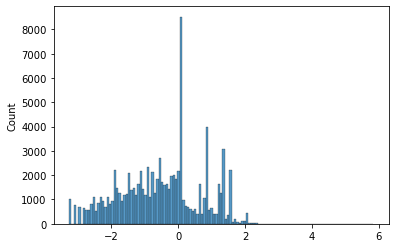

In [153]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy.stats import boxcox
def IQR(x, centering=True):
    p25, p50, p75 = np.percentile(x, [25, 50, 75])
    print(p25, p50, p75)
    if centering:
        return (x - p50) / (p75 - p25)
    else:
        return x / (p75 - p25)

t = df.durata.dt.days
print(sum(t>0) / len(t) *100)
t = t[t>0]
t = IQR(t, centering=False)
t, maxlog = boxcox(t)
# print(maxlog)
sns.histplot(t)

# scatterplots

is the contract duration linearly dependent on the contract amount?

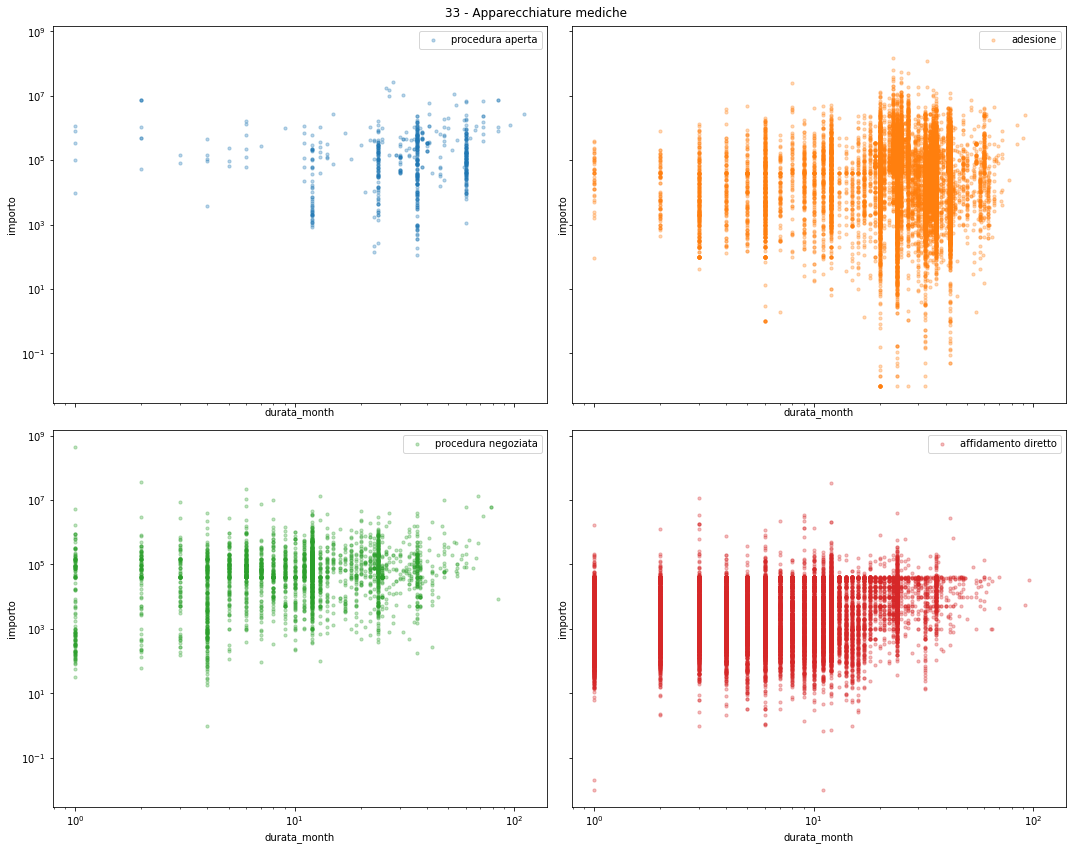

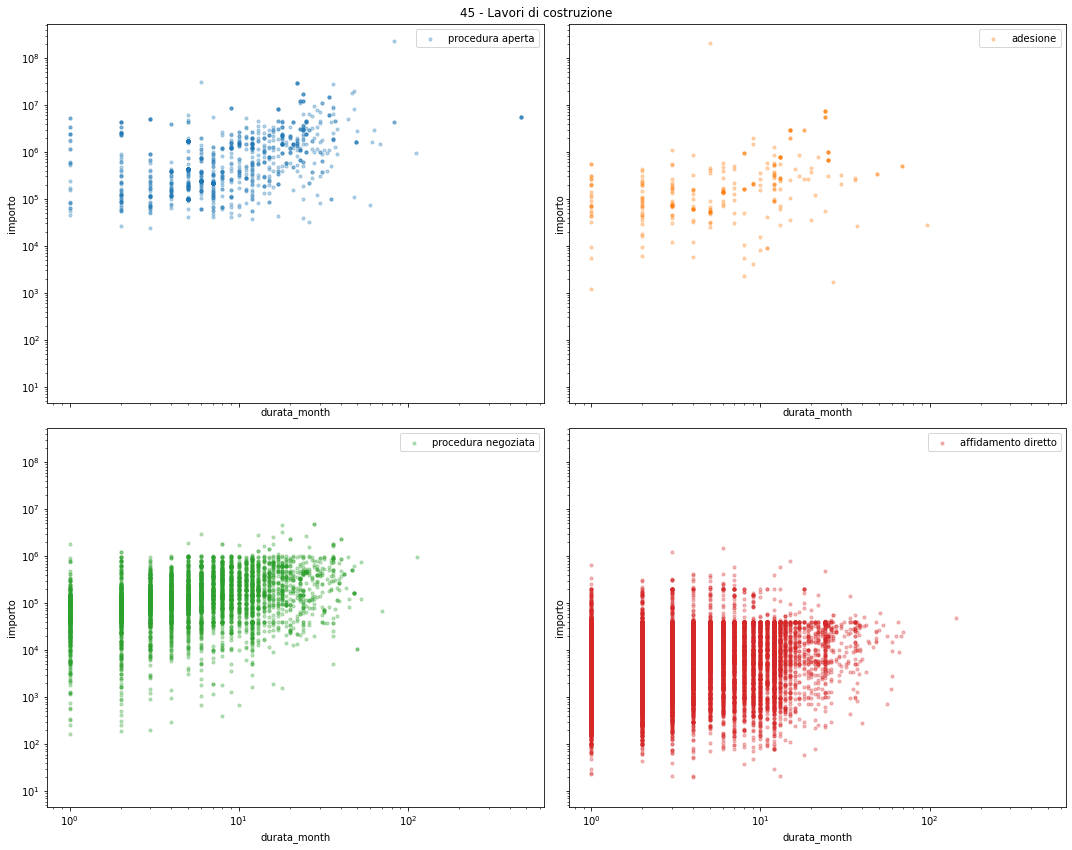

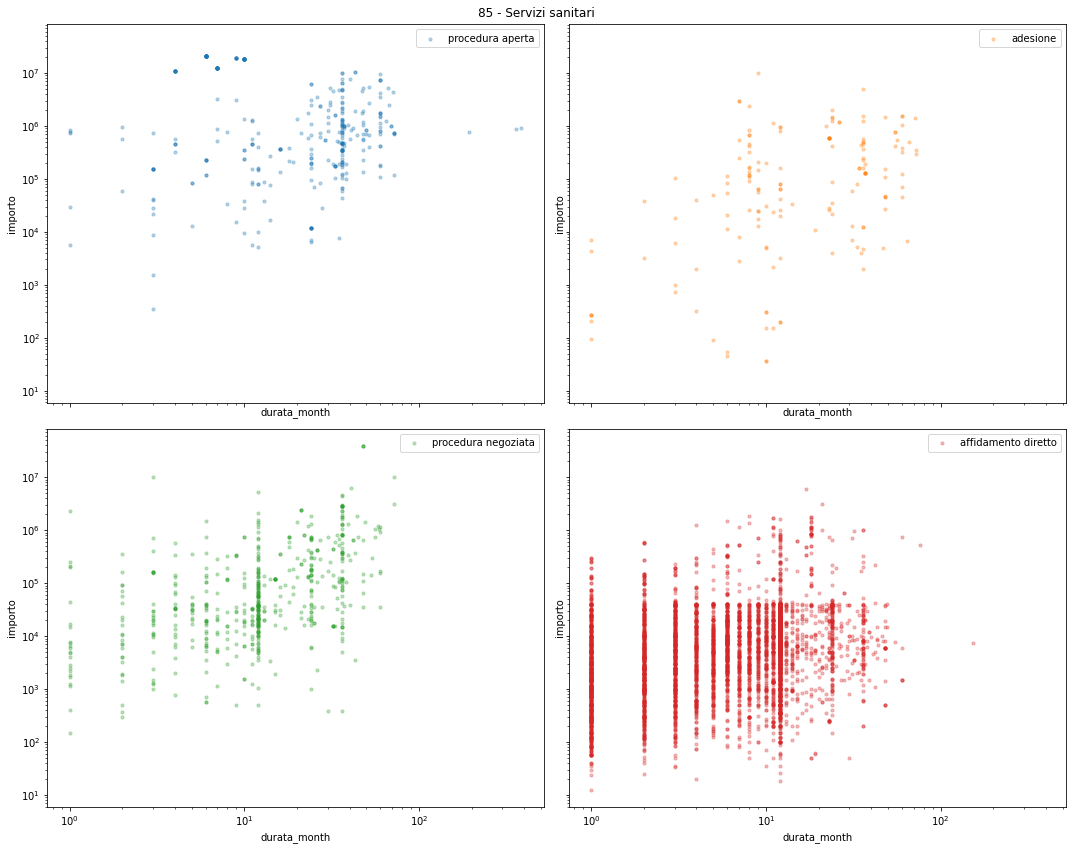

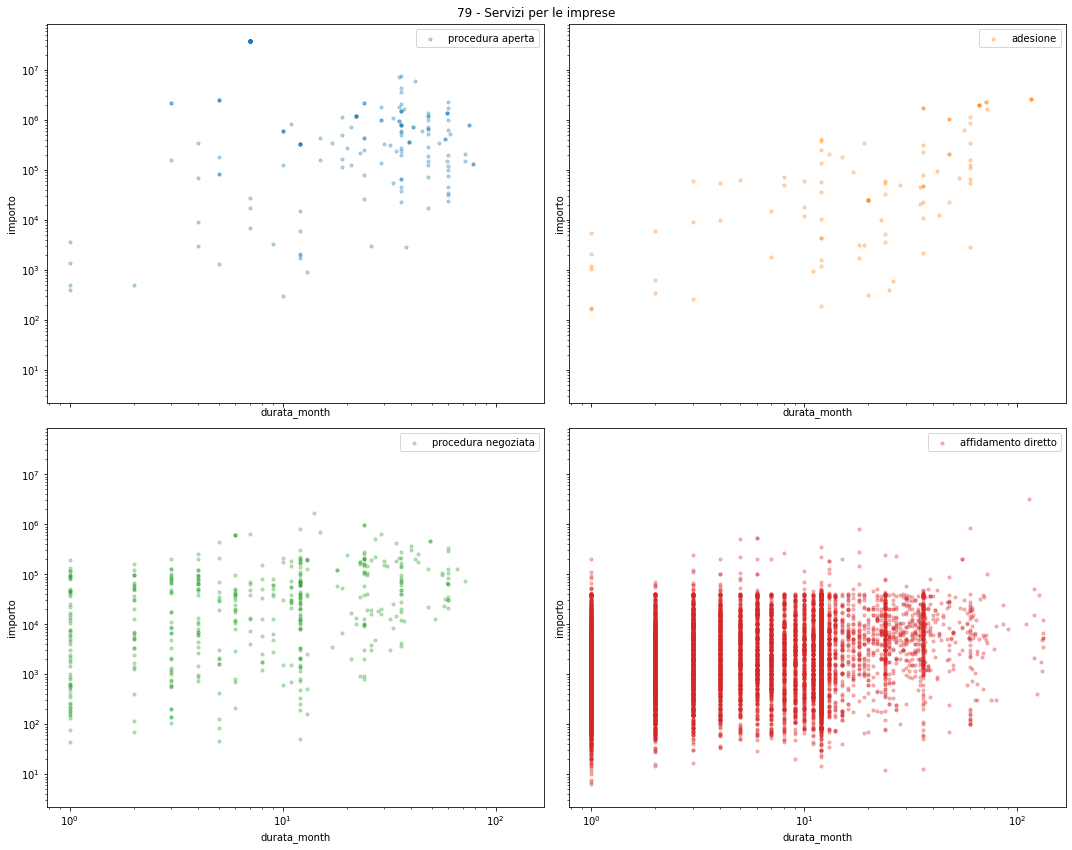

In [4]:
for cpv in abc_cpv:
    utils.scatter_quaternion("durata_month", "importo", df, cpv)

the bigger the contract amount, the bigger the business entity?

In [ ]:
for cpv in abc_cpv:
    utils.scatter_quaternion("median_revenue_be", "importo", df, cpv)

the bigger the contract amount, the bigger the PA median annual expenditure?

In [ ]:
for cpv in abc_cpv:
    utils.scatter_quaternion("median_expenditure_pa","importo", df, cpv)

do big PAs buy from big business entities?

In [ ]:
for cpv in abc_cpv:
    utils.scatter_quaternion("median_revenue_be", "median_expenditure_pa", df, cpv)

# time series

In [ ]:
import matplotlib.colors as mcolors
from matplotlib.dates import MonthLocator, YearLocator, ConciseDateFormatter
n = len(abc_procedures)
fig, ax = plt.subplots(n, figsize=(6*3, 4.5*n))
for i, (name, group) in enumerate(df.groupby("tipo_procedura")):
    aggr = group.groupby("data_inizio").size()
    ax[i].plot(aggr / aggr.sum() , label=name, c=list(mcolors.TABLEAU_COLORS)[i])
    yloc = YearLocator()
    mloc = MonthLocator()
    ax[i].xaxis.set_major_locator(yloc)
    ax[i].xaxis.set_minor_locator(mloc)
    ax[i].grid()
    ax[i].legend()
plt.show()

il picco del numero di contratti nell'intorno dei primi giorni di Maggio del 2018 è dovuto a una gara regionale per l'acquisto di farmaci e vaccini per un'intero biennio.

manca un'analisi della trasformata di Fourier per identificare le ciclicità

In [ ]:
for cpv in abc_cpv:
    fig, ax = plt.subplots(2, 2, figsize=(6*3, 4*3), sharey=True)
    for i, procedure in enumerate(abc_scelta_contraente):
        table = df[(df.cpv == cpv) & (df.id_scelta_contraente == procedure)]
        table.groupby(table.data_inizio.dt.to_period("M")).importo.median().plot(ax=ax[i//2, i%2])
        ax[i//2, i%2].set_yscale("log")
        ax[i//2, i%2].set_title(f"id_scelta_contranente:{procedure}")
        ax[i//2, i%2].grid()
    fig.suptitle(f"cpv: {cpv}")
    plt.tight_layout()

eccetto per l'affidamento diretto, il resto delle procedure non presenta ciclicità rispetto agli importi

In [ ]:
for cpv in abc_cpv:
    fig, ax = plt.subplots(2, 2, figsize=(6*3, 4*3), sharey=True)
    for i, procedure in enumerate(abc_scelta_contraente):
        table = df[(df.cpv == cpv) & (df.id_scelta_contraente == procedure)]
        table.groupby(table.data_inizio.dt.to_period("M")).importo.size().plot(ax=ax[i//2, i%2])
        ax[i//2, i%2].set_yscale("log")
        ax[i//2, i%2].set_title(f"id_scelta_contranente:{procedure}")
        ax[i//2, i%2].grid()
    fig.suptitle(f"cpv: {cpv}")
    plt.tight_layout()

anche qi direi che solo gli affidamenti diretti sono ciclici, mentre gli altri no.

# outlier classification and filtering
* near-illegal outliers. The contracts are not compliant to the at-that-time public procurement law. This is a first approximation as waivers and exceptions are possibile. 
* unsound/unreasable outliers. The contract values are very unrealistic given the other contract dimensions, such as the dimension of the firm or the duration
* statistical outliers. The contracts outlined by the evaluation of a statistical model applied to the dataset filtered of the previous outlier categories

## near-illegal outliers
according to https://www.bosettiegatti.eu/public/2019_memo_pubblicita.pdf

decreto nudo e crudo
http://www.normattiva.it/uri-res/N2Ls?urn:nir:stato:decreto.legislativo:2016-04-18;50

In [ ]:
# append a new col to keep track of the changes
df["uncompliant"] = False

the only award procedures present in the dataset:
* 1 : "procedura aperta",
* 4 : "procedura negoziata",
* 23 : "affidamento diretto"

### works
* affidamento diretto: contract value < 150k
* procedura negoziata: 150k <= contract value < 1M
* procedura aperta: 1M <= contract value < 5.35M
* procedura aperta o ristretta: 5.35M >= contract value

In [ ]:
# cpv does not match the lsf classification
sum(df.id_lsf == 1) - sum((df.id_lsf == 1) & (df.cpv == 45))

Let's forget about them. We will eventually keep them in consideration

In [ ]:
# no dovrebbero esserci affidamenti diretti sopra i 150k
df.loc[(df.id_lsf == 1) & (df.id_scelta_contraente == 23) & (df.importo > 150e3), "uncompliant"] = True
# non dovrebbero esserci procedure negoziata inferiore ai 150k e superiori al milione
df.loc[(df.id_lsf == 1) & (df.id_scelta_contraente == 4) & (df.importo < 150e3), "uncompliant"] = True
df.loc[(df.id_lsf == 1) & (df.id_scelta_contraente == 4) & (df.importo > 1e6), "uncompliant"] = True
# non dovrebbero esserci procedure aperte inferiori al 1M di euro
df.loc[(df.id_lsf == 1) & (df.id_scelta_contraente == 1) & (df.importo < 1e6), "uncompliant"] = True


### goods and services
* affidamento diretto: contract value < 40k
* procedura negoziata: 40k <= contract value < 214k
* procedura aperta o ristretta: 214k >= contract value

In [ ]:
# non dovrebbero esserci affidamenti diretti sopra i 40k
df.loc[(df.id_lsf != 1) & (df.id_scelta_contraente == 23) & (df.importo > 40e3), "uncompliant"] = True
# non dovrebbero esserci procedure negoziata inferiore ai 40k e superiori al 214k
df.loc[(df.id_lsf != 1) & (df.id_scelta_contraente == 4) & (df.importo > 214e3), "uncompliant"] = True
df.loc[(df.id_lsf != 1) & (df.id_scelta_contraente == 4) & (df.importo < 40e3), "uncompliant"] = True
# non dovrebbero esserci procedure aperte o ristrette sotto i 214k
df.loc[(df.id_lsf != 1) & (df.id_scelta_contraente == 1) & (df.importo < 214e3), "uncompliant"] = True


incompatibile smarti CIG con negoziata. 

In [ ]:
sum(df.uncompliant)

## unsound/unreasonable outliers

1. contracts having a value higher than the median annual revenue of the business entity winning the bid and of the median expenditure of the public commissioning body (stazione appaltante). Both the business entity and the commissioning body must have a median annual number of contracts higher or equal than five.

In [ ]:
df["unsound"] = False

In [ ]:
min_year_contr_th = 5
rev_exp_mask = (df.importo > df.median_revenue_be) & (df.importo > df.median_expenditure_pa)
min_year_contr_mask = (df.med_yearly_n_contr_be > min_year_contr_th) & (df.med_yearly_n_contr_pa > min_year_contr_th)
df.loc[rev_exp_mask & min_year_contr_mask, "unsound"] = True

In [ ]:
relevant_attributes = ["importo", "cpv", "durata", 
                       "median_revenue_be", "med_yearly_n_contr_be", 
                       "median_expenditure_pa", "med_yearly_n_contr_pa"]
df[df.unsound][relevant_attributes]

2. affidamenti diretti having contract duration lasting longer than 10 years

In [ ]:
n_years = 10
years_mask = (df.id_scelta_contraente == 23) & (df.durata.dt.days > n_years * 365)
sum(years_mask)
df.loc[years_mask, "unsound"] = True
df[years_mask][relevant_attributes]

3. contracts having a value 25 times higher than the median revenue of business entity and more than 5 contracts (median)

In [ ]:
coef = 25
coef_mask = (df.importo > coef * df.median_revenue_be) & (df.med_yearly_n_contr_be > 5)
df.loc[coef_mask, "unsound"] = True
df.loc[coef_mask, relevant_attributes]

4. contratti con importi inferiori a 1 euro? che roba è? ci sono contratti da a 0.1 a 1 euro nel caso di forniture di farmaci

In [ ]:
df.loc[df.importo < 1, "unsound"] = True

In [ ]:
# utils.compare_filtering(df, "median_revenue_be", "importo", "uncompliant")
# 1: uncompliant contracts
# 0: compliant contracts

In [ ]:
utils.compare_filtering(df, "median_revenue_be", "importo","unsound", alpha=.5)

# da chiedere a Claudio:
1. sono le gare o i lotti a dover rispettare i vincoli di cui sopra?
2. quanto scorretto è che esistano gare che non rispettino i limiti di cui sopra? sono relativamente comuni le infrazioni al codice degli appalti

CIG con numero: non smart
CIG XYZ età: smart CIG e sono affidamenti diretti.

Id è del lotto, non della gara. ma le regole fanno riferimento alle gare. 
Cambiamo d’ufficio la procedura ad affidamento diretto se smart CIG. assunzione che Claudio 

abbiamo l'id dei lotti, non delle gare. 


per quali tipi di contratti è richiesto lo smart CIG.
https://www.anticorruzione.it/-/tracciabilit%C3%A0-dei-flussi-finanziari?redirect=%2Fchiedilo-ad-anac%2F-%2Fcategories%2F34206%3Fp_r_p_resetCur%3Dtrue%26p_r_p_categoryId%3D34206, faq 7.1

conta la prassi, non la teoria. L'assunzione è che noi non conosciamo tutti i dati a riguardo quindi non possiamo assumere che i contratti sono sbagliati se non rispettano la legge.

In [ ]:
sum(df.uncompliant)

In [ ]:
# percentuale di contratti "near-illegal"
sum(df.uncompliant) / df.shape[0] * 100

In [ ]:
# MEDIAN REVENUE
from utils import color_procedure, abc_procedure_names, abc_cpv_names
for cpv in abc_cpv:
    fig, ax = plt.subplots(2, 2, sharex=True)
    for i, procedure in enumerate(abc_scelta_contraente):
        table = df[(df.id_scelta_contraente == procedure) & (df.cpv == cpv)]
        sns.histplot(np.log10(np.unique(table.median_revenue_be)), ax=ax[i//2, i%2], 
                     color=color_procedure[procedure], label=abc_procedure_names[procedure])
        ax[i//2, i%2].legend()
        ax[i//2, i%2].set_xlabel("median revenue be")
    fig.suptitle(f"cpv: {abc_cpv_names[cpv]}")
    plt.tight_layout()

In [ ]:
# MEDIAN EXPENDITURE PA
from utils import color_procedure, abc_procedure_names, abc_cpv_names
for cpv in abc_cpv:
    fig, ax = plt.subplots(2, 2, sharex=True)
    for i, procedure in enumerate(abc_scelta_contraente):
        table = df[(df.id_scelta_contraente == procedure) & (df.cpv == cpv)]
        sns.histplot(np.log10(np.unique(table.median_expenditure_pa)), ax=ax[i//2, i%2], 
                     color=color_procedure[procedure], label=abc_procedure_names[procedure])
        ax[i//2, i%2].legend()
        ax[i//2, i%2].set_xlabel("median expenditure pa")
    fig.suptitle(f"cpv: {abc_cpv_names[cpv]}")
    plt.tight_layout()

In [ ]:
relevant_features = ["importo", "median_expenditure_pa", "median_revenue_be", "contr_med_pa", "contr_med_be", "med_yearly_n_contr_pa", "med_yearly_n_contr_be"]
df[relevant_features].corr()

dft = df[(df.cpv == 33) & (df.id_scelta_contraente==1)][relevant_features].copy()
dft = np.log10(dft)
# for col in dft.columns:
#     dft.loc[:, col] = np.log10(dft[col])

sns.heatmap(dft.corr())

la più alta correlazione è tra la mediano l'erogato/ricavi totali in un anno e il numero di contratti annuali. 
Onestamente era più o meno quello che mi aspettavo. 
Invece il contratto mediano non è troppo correlato l'importo, quindi direi di tenerli. 

In [ ]:


df[(df.cpv == 33) & (df.id_scelta_contraente==1)][relevant_features].corr()

dft = df[(df.cpv == 33) & (df.id_scelta_contraente==1)][relevant_features].copy()
dft = np.log10(dft)
# for col in dft.columns:
#     dft.loc[:, col] = np.log10(dft[col])

sns.heatmap(dft.corr())

# uber forma giurdica rispetto agli importi

In [ ]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(data=df[(df.cpv == 33) & (df.id_scelta_contraente==1)], x="median_expenditure_pa", y="importo", hue="uber_forma_giuridica_pa")
plt.yscale("log")
plt.xscale("log")


In [ ]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(data=df, x="median_expenditure_pa", y="importo", hue="uber_forma_giuridica_be", alpha=.3)
plt.yscale("log")
plt.xscale("log")

histogram of duration

In [ ]:
df[(df.cpv==33) & (df.id_scelta_contraente==26)].durata.dt.days

In [ ]:
sns.histplot(x=df[(df.cpv==33) & (df.id_scelta_contraente==26)].durata.dt.days, bins=12)
plt.axvline(365)
plt.axvline(365*2)
plt.axvline(365*3)
plt.axvline(365*3.5)
plt.axvline(365*4)